# 1.Data preprocessing

## 1.1 Import packages

In [122]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format',lambda x:'%.2f' % x)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import auc,roc_auc_score,roc_curve,recall_score,accuracy_score,classification_report

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


## 1.2 Decoding data

In [123]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [124]:
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.00,-11.88,10.07,-9.83,-2.07,-5.36,-2.61,-4.92,7.31,1.91,...,0.21,0.11,1.01,-0.51,1.44,0.25,0.94,0.82,0.77,0
284803,172787.00,-0.73,-0.06,2.04,-0.74,0.87,1.06,0.02,0.29,0.58,...,0.21,0.92,0.01,-1.02,-0.61,-0.40,0.07,-0.05,24.79,0
284804,172788.00,1.92,-0.30,-3.25,-0.56,2.63,3.03,-0.30,0.71,0.43,...,0.23,0.58,-0.04,0.64,0.27,-0.09,0.00,-0.03,67.88,0
284805,172788.00,-0.24,0.53,0.70,0.69,-0.38,0.62,-0.69,0.68,0.39,...,0.27,0.80,-0.16,0.12,-0.57,0.55,0.11,0.10,10.00,0
284806,172792.00,-0.53,-0.19,0.70,-0.51,-0.01,-0.65,1.58,-0.41,0.49,...,0.26,0.64,0.38,0.01,-0.47,-0.82,-0.00,0.01,217.00,0


In [125]:
print(data.shape)
data.info()

(284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 2

In [126]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.00,94813.86,47488.15,0.00,54201.50,84692.00,139320.50,172792.00
V1,284807.00,0.00,1.96,-56.41,-0.92,0.02,1.32,2.45
V2,284807.00,0.00,1.65,-72.72,-0.60,0.07,0.80,22.06
V3,284807.00,-0.00,1.52,-48.33,-0.89,0.18,1.03,9.38
V4,284807.00,0.00,1.42,-5.68,-0.85,-0.02,0.74,16.88
V5,284807.00,0.00,1.38,-113.74,-0.69,-0.05,0.61,34.80
V6,284807.00,0.00,1.33,-26.16,-0.77,-0.27,0.40,73.30
V7,284807.00,-0.00,1.24,-43.56,-0.55,0.04,0.57,120.59
V8,284807.00,0.00,1.19,-73.22,-0.21,0.02,0.33,20.01
V9,284807.00,-0.00,1.10,-13.43,-0.64,-0.05,0.60,15.59


<Axes: >

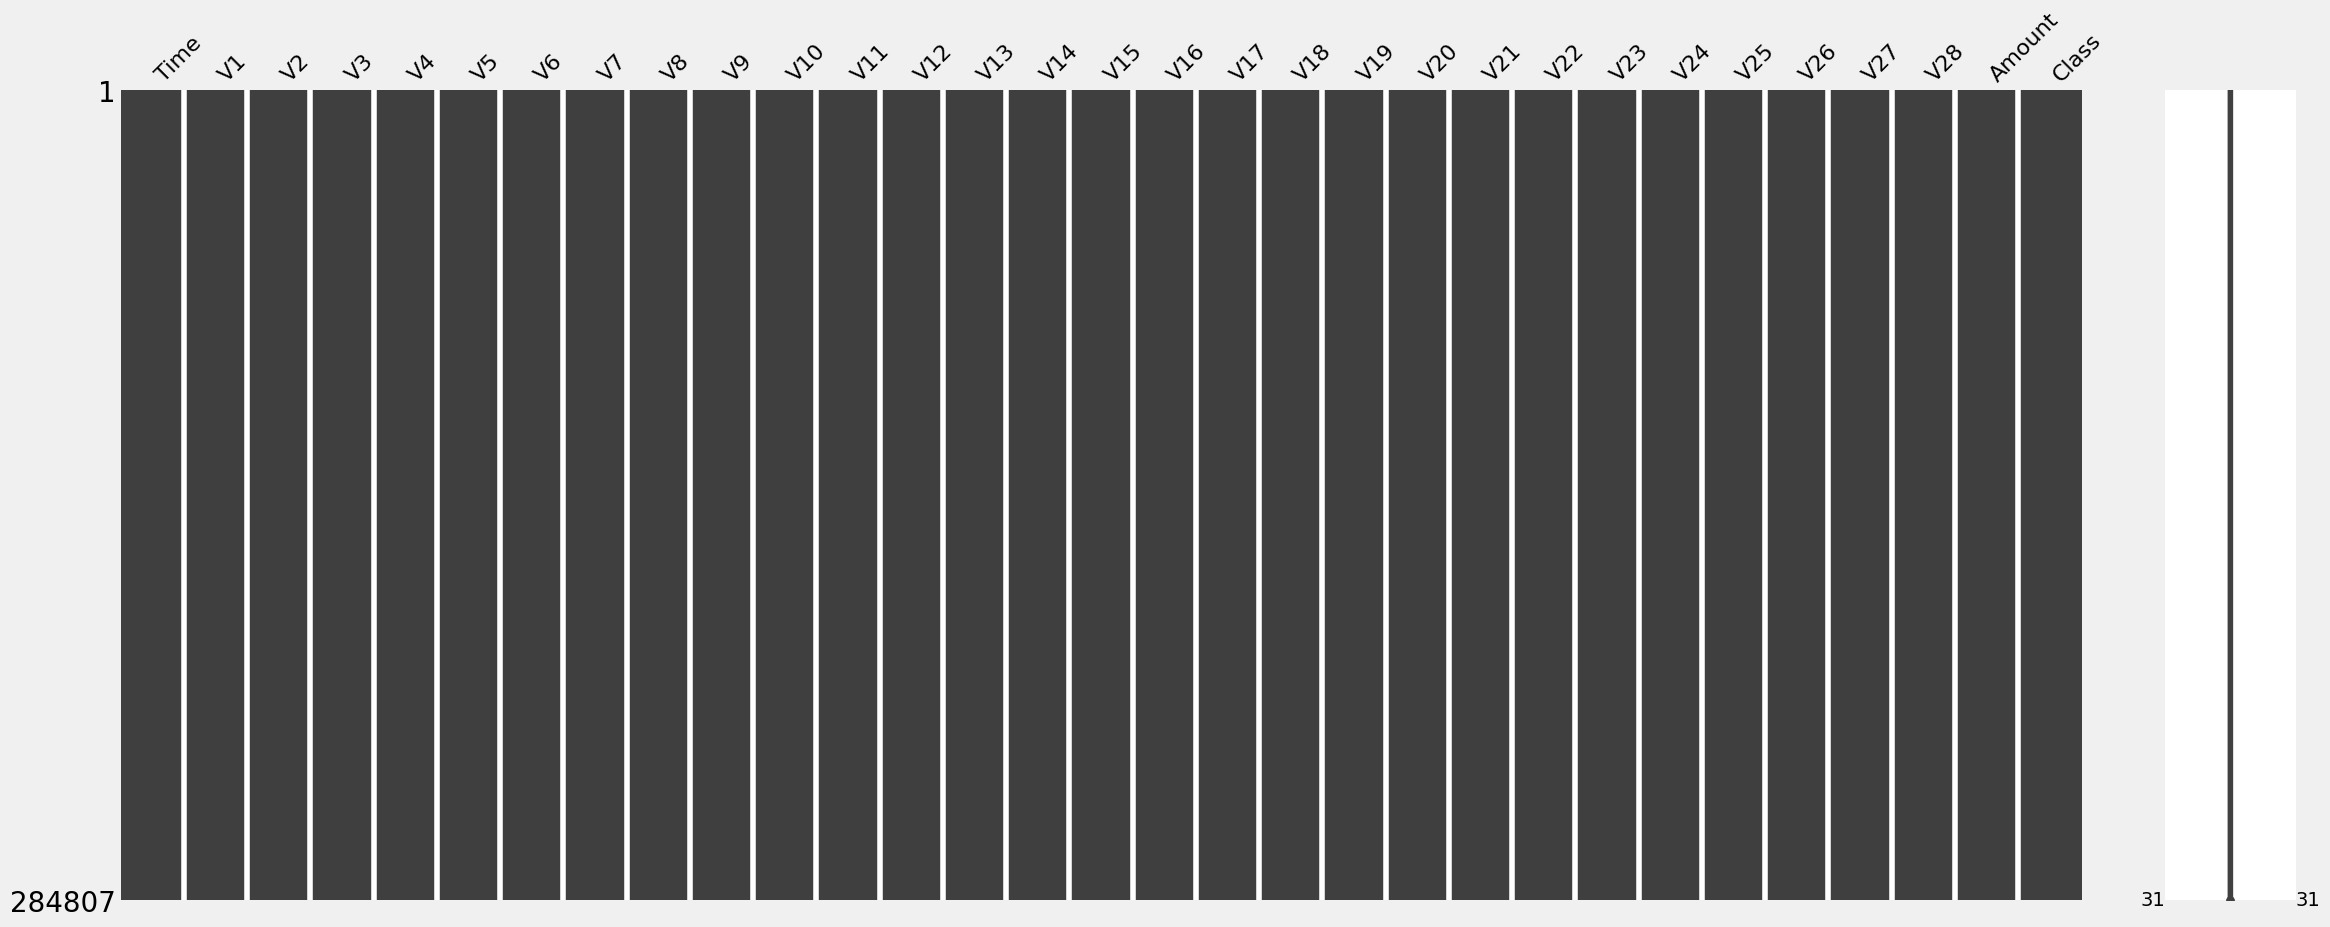

In [127]:
msno.matrix(data)

In [128]:
data.isnull().sum().sum()

0

# 2.Feature engineering

## 2.1 Target variable

Text(0.5, 1.0, 'Percent of each Class')

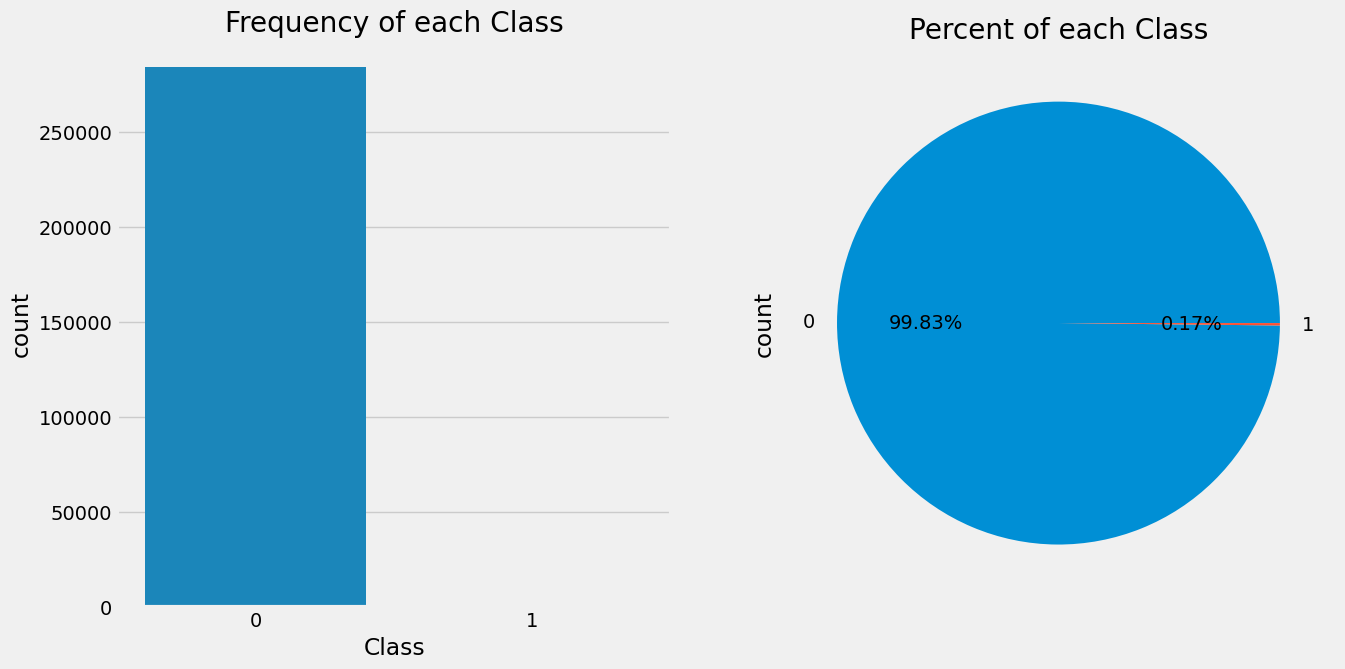

In [129]:
fig,axs = plt.subplots(1,2,figsize=(14,7))

sns.countplot(x='Class',data=data,ax=axs[0])
axs[0].set_title('Frequency of each Class')

data['Class'].value_counts().plot(kind='pie',ax=axs[1],autopct='%1.2f%%')
axs[1].set_title('Percent of each Class')

In [130]:
data.groupby(by='Class').size()

Class
0    284315
1       492
dtype: int64

The dataset is very imbalanced

## 2.2 Feature derivation

In [131]:
data.head() # Time is measured in seconds and is too discrete

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [132]:
data['Hour'] = data['Time'].apply(lambda x: divmod(x,3600)[0])
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0,0.00
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0,0.00
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0,0.00
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0,0.00
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.00,-11.88,10.07,-9.83,-2.07,-5.36,-2.61,-4.92,7.31,1.91,...,0.11,1.01,-0.51,1.44,0.25,0.94,0.82,0.77,0,47.00
284803,172787.00,-0.73,-0.06,2.04,-0.74,0.87,1.06,0.02,0.29,0.58,...,0.92,0.01,-1.02,-0.61,-0.40,0.07,-0.05,24.79,0,47.00
284804,172788.00,1.92,-0.30,-3.25,-0.56,2.63,3.03,-0.30,0.71,0.43,...,0.58,-0.04,0.64,0.27,-0.09,0.00,-0.03,67.88,0,47.00
284805,172788.00,-0.24,0.53,0.70,0.69,-0.38,0.62,-0.69,0.68,0.39,...,0.80,-0.16,0.12,-0.57,0.55,0.11,0.10,10.00,0,47.00


# 3.Feature selection

## 3.1 Credit Card Normal Spending vs. Fraud

Text(0.5, 1.0, 'Fraud')

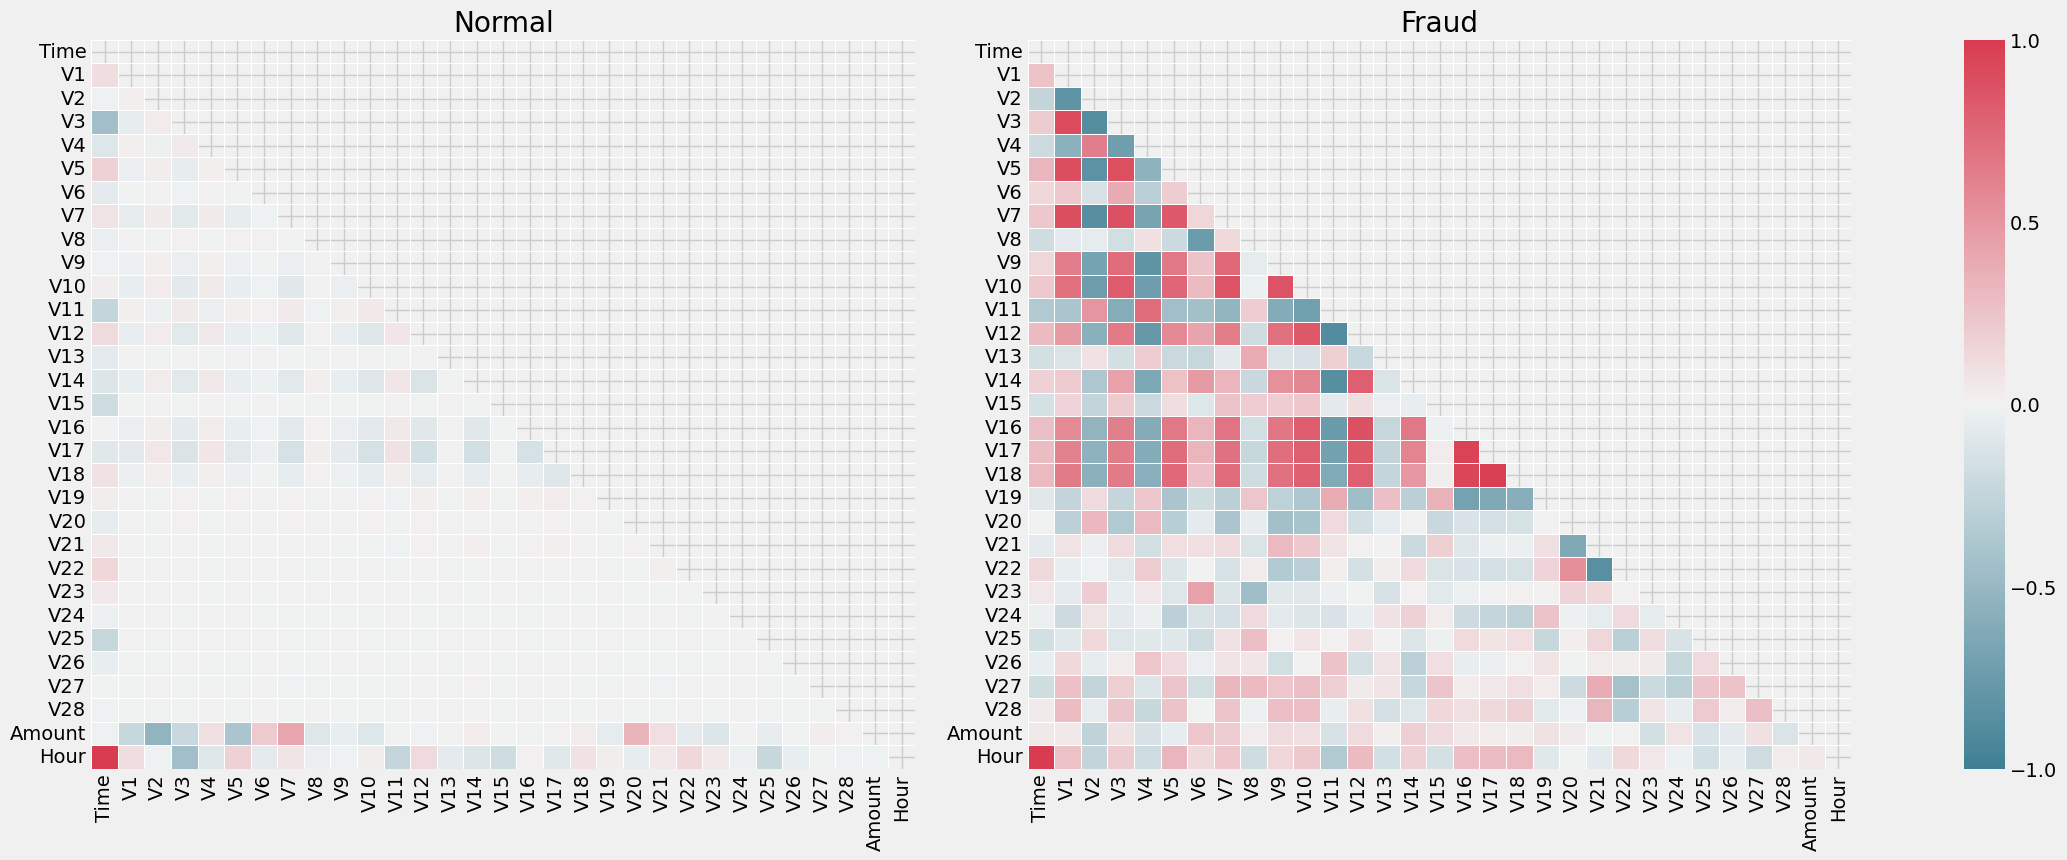

In [133]:
XFraud = data.loc[data['Class'] == 1] ## Fraud
XnonFraud = data.loc[data['Class'] == 0] ## Normal spending

correlationNonFraud = XnonFraud.loc[:,data.columns != 'Class'].corr()

mask = np.zeros_like(correlationNonFraud)

index = np.triu_indices_from(correlationNonFraud) ## Index of the upper right part
mask[index] = True

kw = {'width_ratios':[1,1,0.05],'wspace':0.2}
f,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw=kw,figsize = (22,9))

cmap = sns.diverging_palette(220,8,as_cmap= True) # Series of colors
sns.heatmap(correlationNonFraud,ax=ax1,vmin=-1,vmax=1,square=False,
            linewidths=0.5,mask=mask,cbar=False,cmap= cmap)
ax1.set_title('Normal')

correlationFraud = XFraud.loc[:,data.columns != 'Class'].corr()
sns.heatmap(correlationFraud,vmin=-1,vmax=1,cmap=cmap,ax=ax2,
            square=False,linewidths=0.5,mask=mask,yticklabels=True,cbar_ax=ax3,
            cbar_kws={'orientation':'vertical','ticks':[-1,-0.5,0,0.5,1]})
ax2.set_title('Fraud')

<div align="justify">

As can be seen from the graph above, the correlation between some of the variables is more pronounced in the case of credit card Fraud. Among the variables V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V14,V16,V17 and V18 as well as V19 show a certain pattern of variation among the samples of fraud credit cards.

Characteristics V8,V13,V15,V20,V21,V22,V23,V24,V25,V26,V27 and V28 show no significant pattern!

</div>

## 3.2 Amount and number of transactions

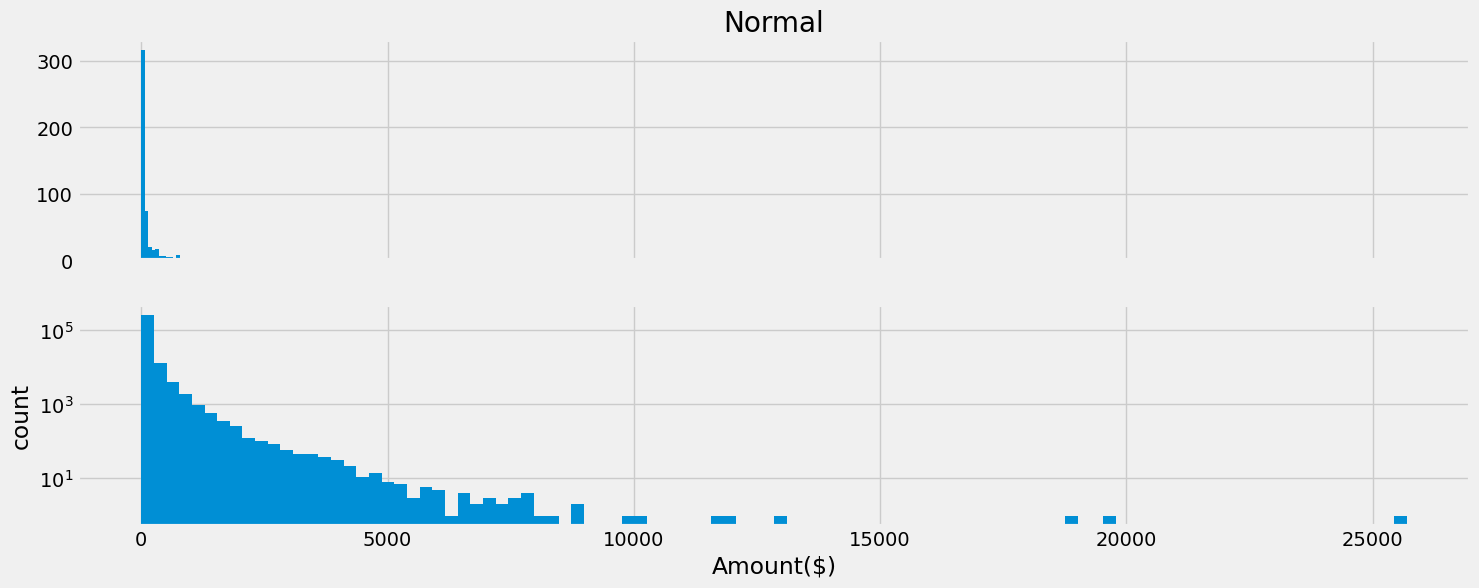

In [134]:
f,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(16,6))

ax1.hist(data['Amount'][data['Class'] == 1],bins=30)
ax1.set_title('Fraud')

ax2.hist(data['Amount'][data['Class'] == 0],bins=100)
ax1.set_title('Normal')

plt.xlabel('Amount($)')
plt.ylabel('count')
plt.yscale('log')


The amount of credit card theft occurs compared with the amount of normal credit card users show scattered and small characteristics, which indicates that credit card thieves in order not to attract the attention of the credit card card owners, more inclined to choose a small amount of consumption.

## 3.3 Credit card fraud time

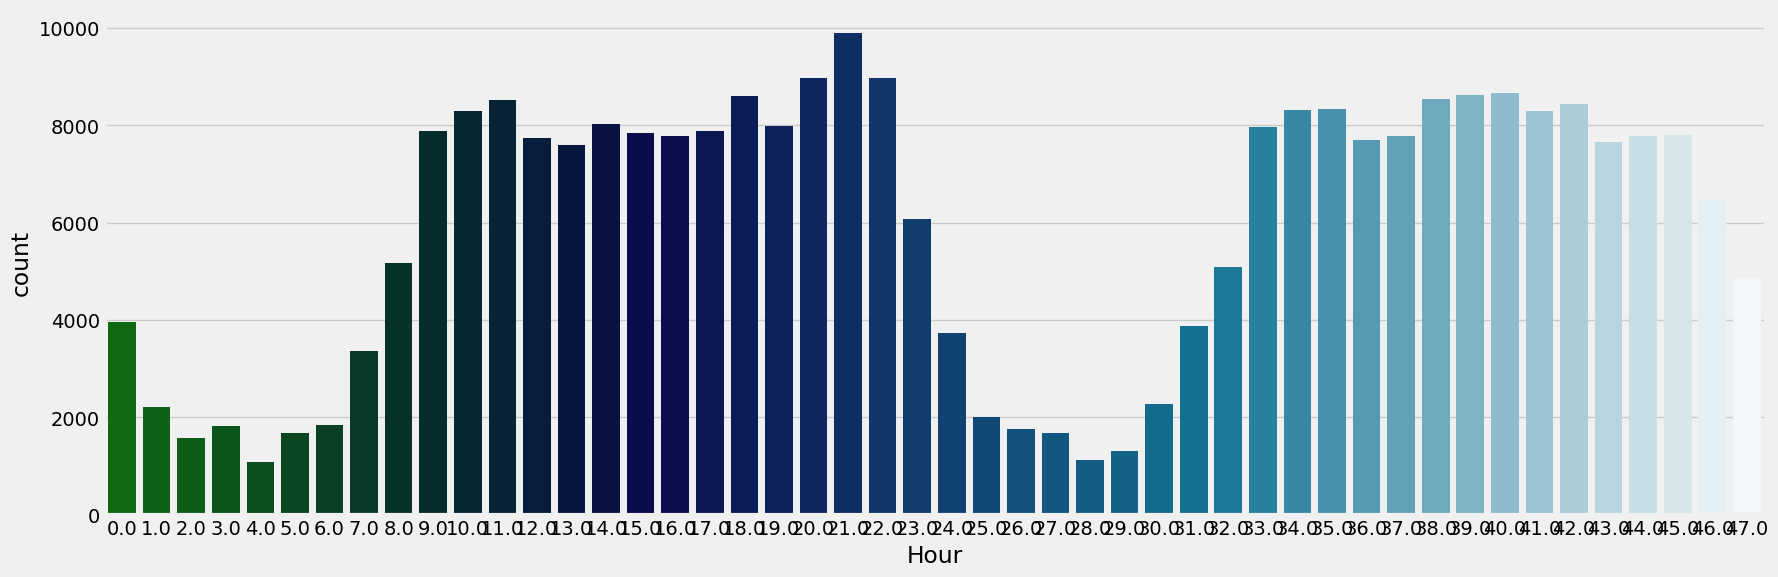

In [135]:
sns.catplot(x='Hour', data=data, kind='count', palette='ocean', height=6, aspect=3)

## 3.4 Relationship between transaction amount and transaction time

Text(0.5, 1.0, 'Normal')

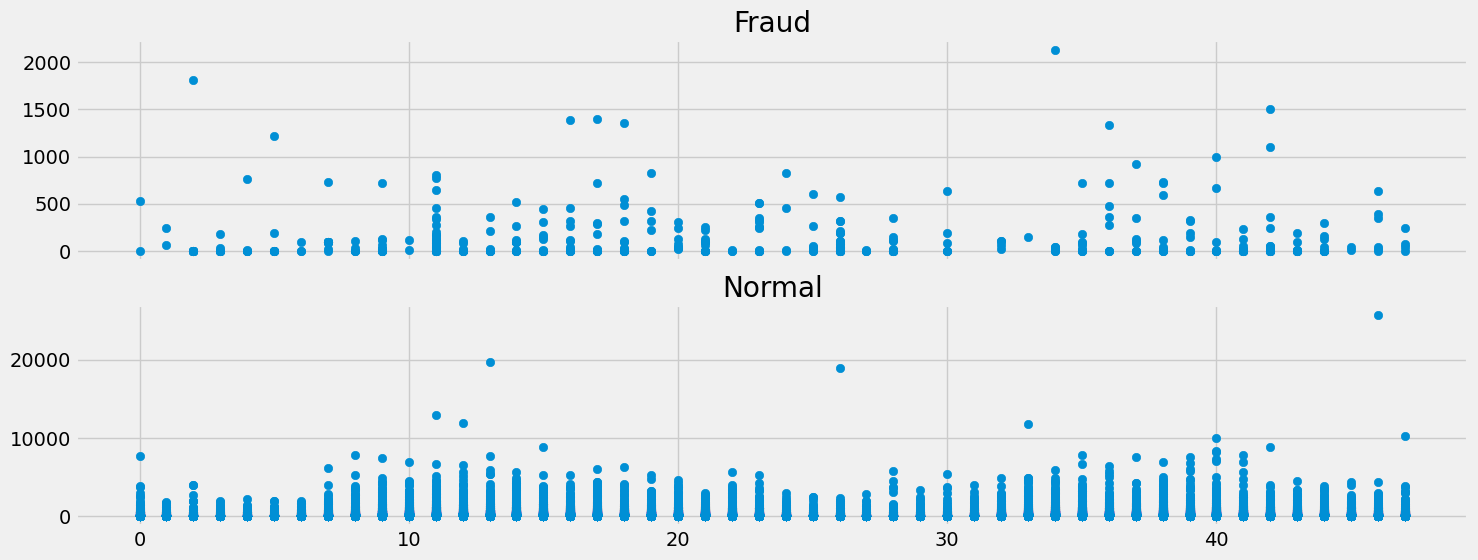

In [136]:
f,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize = (16,6))

cond1 = data['Class'] == 1

ax1.scatter(data['Hour'][cond1],data['Amount'][cond1])
ax1.set_title('Fraud')

cond2 = data['Class'] == 0

ax2.scatter(data['Hour'][cond2],data['Amount'][cond2])
ax2.set_title('Normal')



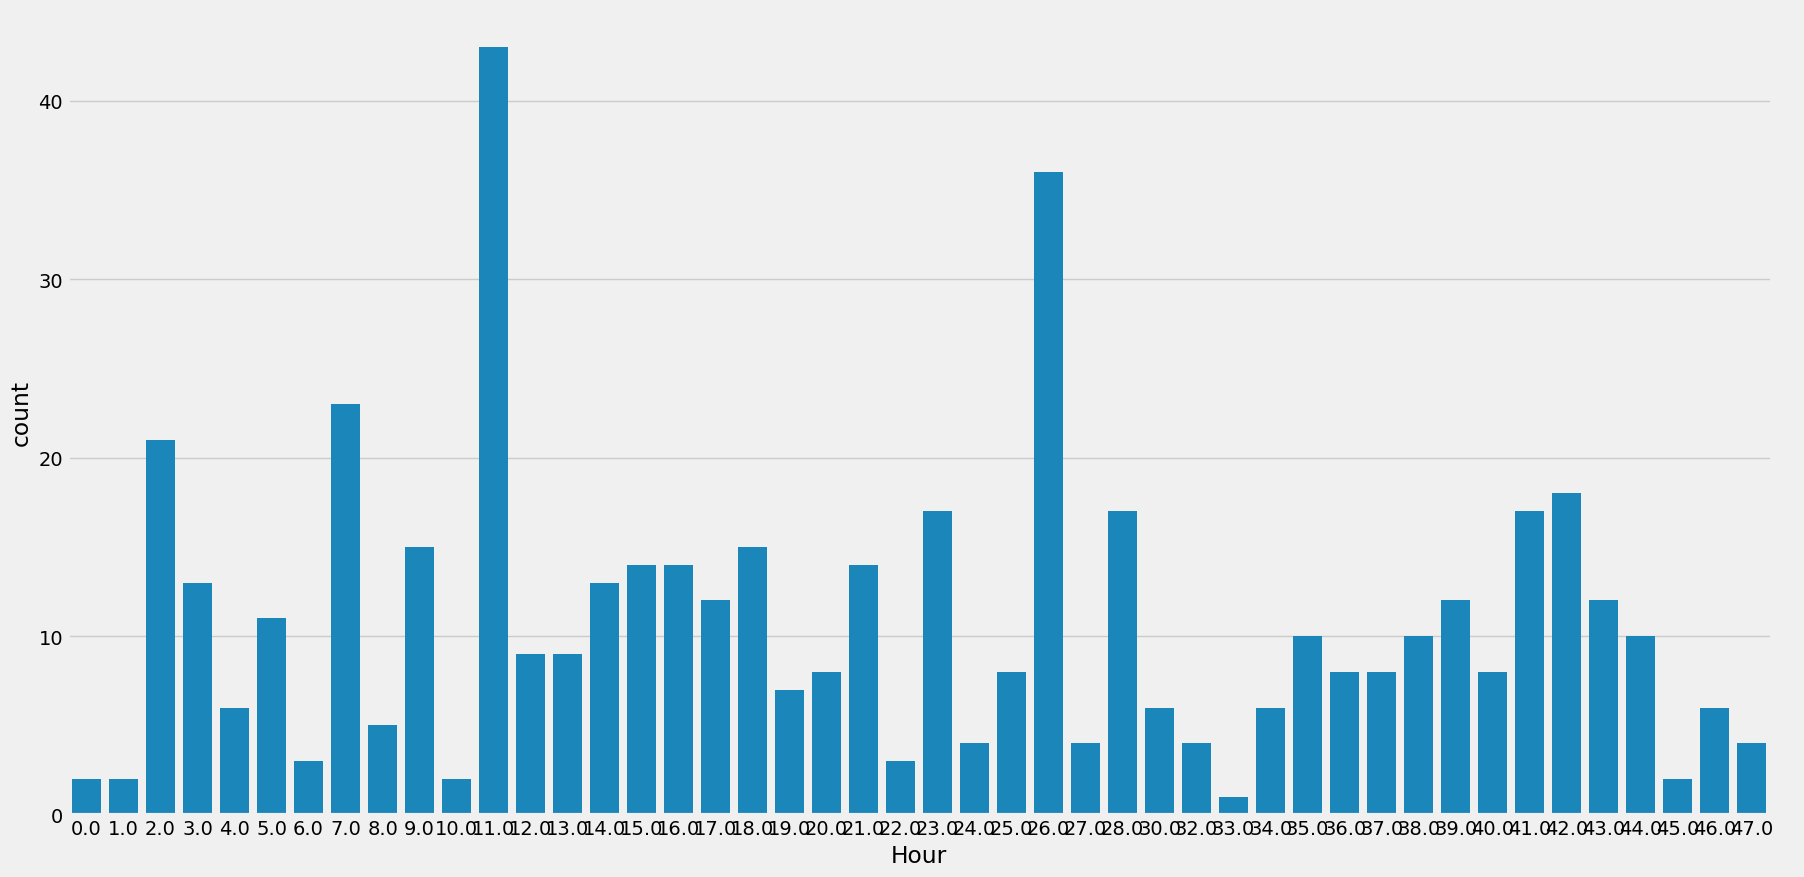

In [137]:
sns.catplot(x='Hour',kind='count',data = data[cond1],height=9,aspect=2)

In [138]:
data['Amount'][cond1].max()

2125.87

<div align="justify">

As can be seen from the above figure, in the stolen credit card sample, the outliers occurred during a time period when credit card purchases were more infrequent. The highest number of credit card theft peaked at 11:00 a.m. on the first day and reached 43 times, while the rest occurred between 11:00 p.m. and 9:00 a.m. on the next day, indicating that credit card skimmers preferred to choose the time when credit card owners slept and spent more frequently in order to avoid attracting the attention of credit card owners. At the same time, the maximum value of credit card theft was only US$2,125.87.

</div>

## 3.5 Feature Distribution View (Helping us to select features)

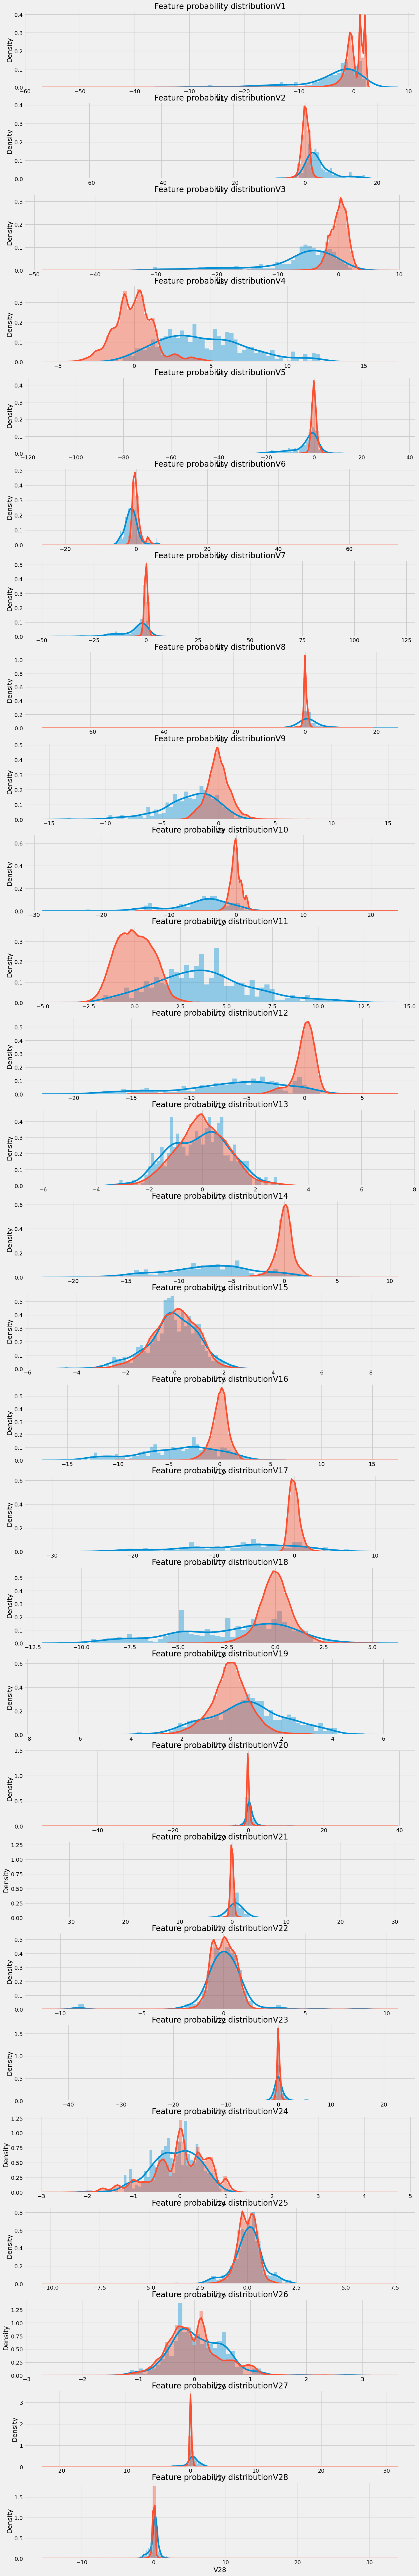

In [139]:
v_feat = data.iloc[:,1:29].columns

plt.figure(figsize=(16,4 * 28))
cond1 = data['Class'] == 1
cond2 = data['Class'] == 0

gs = gridspec.GridSpec(28,1)
for i,cn in enumerate(v_feat):
    ax = plt.subplot(gs[i])

    sns.distplot(data[cn][cond1],bins=50)
    sns.distplot(data[cn][cond2],bins=100)
    ax.set_title('Feature probability distribution' + cn)

<div align="justify">

The figure above shows the different distributions of different variables for stolen credit cards and normal credit cards, and we will choose variables whose distributions are significantly different across credit card status. Therefore variables V8,V13,V15,V20,V21,V22,V23,V24,V25,V26,V27 and V28 variables are excluded. This is also consistent with the conclusions we began to draw with the correlation mapping observations. Also excluding the variable Time and keeping the less discrete Hour variable.

</div>

In [140]:
droplist = ['V8','V13','V15','V20','V21','V22','V23','V24','V25','V26','V27','V28','Time']

data_new = data.drop(labels=droplist,axis = 1)
display(data.shape,data_new.shape)

(284807, 32)

(284807, 19)

In [141]:
data_new.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,Amount,Class,Hour
0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.36,0.09,-0.55,-0.62,-0.31,-0.47,0.21,0.03,0.40,149.62,0,0.00
1,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,-0.26,-0.17,1.61,1.07,-0.14,0.46,-0.11,-0.18,-0.15,2.69,0,0.00
2,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,-1.51,0.21,0.62,0.07,-0.17,-2.89,1.11,-0.12,-2.26,378.66,0,0.00
3,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,-1.39,-0.05,-0.23,0.18,-0.29,-1.06,-0.68,1.97,-1.23,123.50,0,0.00
4,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,0.82,0.75,-0.82,0.54,-1.12,-0.45,-0.24,-0.04,0.80,69.99,0,0.00


# 4.Feature scaling

In [142]:
col = ['Amount','Hour']
sc = StandardScaler()

data_new[col] = sc.fit_transform(data_new[col])
data_new.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,Amount,Class,Hour
0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.36,0.09,-0.55,-0.62,-0.31,-0.47,0.21,0.03,0.40,0.24,0,-1.96
1,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,-0.26,-0.17,1.61,1.07,-0.14,0.46,-0.11,-0.18,-0.15,-0.34,0,-1.96
2,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,-1.51,0.21,0.62,0.07,-0.17,-2.89,1.11,-0.12,-2.26,1.16,0,-1.96
3,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,-1.39,-0.05,-0.23,0.18,-0.29,-1.06,-0.68,1.97,-1.23,0.14,0,-1.96
4,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,0.82,0.75,-0.82,0.54,-1.12,-0.45,-0.24,-0.04,0.80,-0.07,0,-1.96


In [143]:
data_new.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,284807.00,0.00,1.96,-56.41,-0.92,0.02,1.32,2.45
V2,284807.00,0.00,1.65,-72.72,-0.60,0.07,0.80,22.06
V3,284807.00,-0.00,1.52,-48.33,-0.89,0.18,1.03,9.38
V4,284807.00,0.00,1.42,-5.68,-0.85,-0.02,0.74,16.88
V5,284807.00,0.00,1.38,-113.74,-0.69,-0.05,0.61,34.80
V6,284807.00,0.00,1.33,-26.16,-0.77,-0.27,0.40,73.30
V7,284807.00,-0.00,1.24,-43.56,-0.55,0.04,0.57,120.59
V9,284807.00,-0.00,1.10,-13.43,-0.64,-0.05,0.60,15.59
V10,284807.00,0.00,1.09,-24.59,-0.54,-0.09,0.45,23.75
V11,284807.00,0.00,1.02,-4.80,-0.76,-0.03,0.74,12.02


# 5.Feature importance

In [144]:
feature = list(data_new.columns)
print(feature)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'Amount', 'Class', 'Hour']


In [145]:
feature.remove('Class')
feature

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'Amount',
 'Hour']

In [146]:
X = data_new[feature]
y = data_new['Class']
display(X.head(),y.head())

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,Amount,Hour
0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.36,0.09,-0.55,-0.62,-0.31,-0.47,0.21,0.03,0.40,0.24,-1.96
1,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,-0.26,-0.17,1.61,1.07,-0.14,0.46,-0.11,-0.18,-0.15,-0.34,-1.96
2,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,-1.51,0.21,0.62,0.07,-0.17,-2.89,1.11,-0.12,-2.26,1.16,-1.96
3,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,-1.39,-0.05,-0.23,0.18,-0.29,-1.06,-0.68,1.97,-1.23,0.14,-1.96
4,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,0.82,0.75,-0.82,0.54,-1.12,-0.45,-0.24,-0.04,0.80,-0.07,-1.96


0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [147]:
clf = RandomForestClassifier()

clf.fit(X,y)
clf.feature_importances_

array([0.02040416, 0.01542547, 0.01925493, 0.0350856 , 0.01671825,
       0.02176453, 0.03076222, 0.03011469, 0.09938623, 0.05457133,
       0.18118176, 0.1279868 , 0.06207387, 0.19608244, 0.03724106,
       0.01723284, 0.01912608, 0.01558775])

In [148]:
plt.rcParams['figure.figsize'] = (12,6)
plt.style.use('fivethirtyeight')

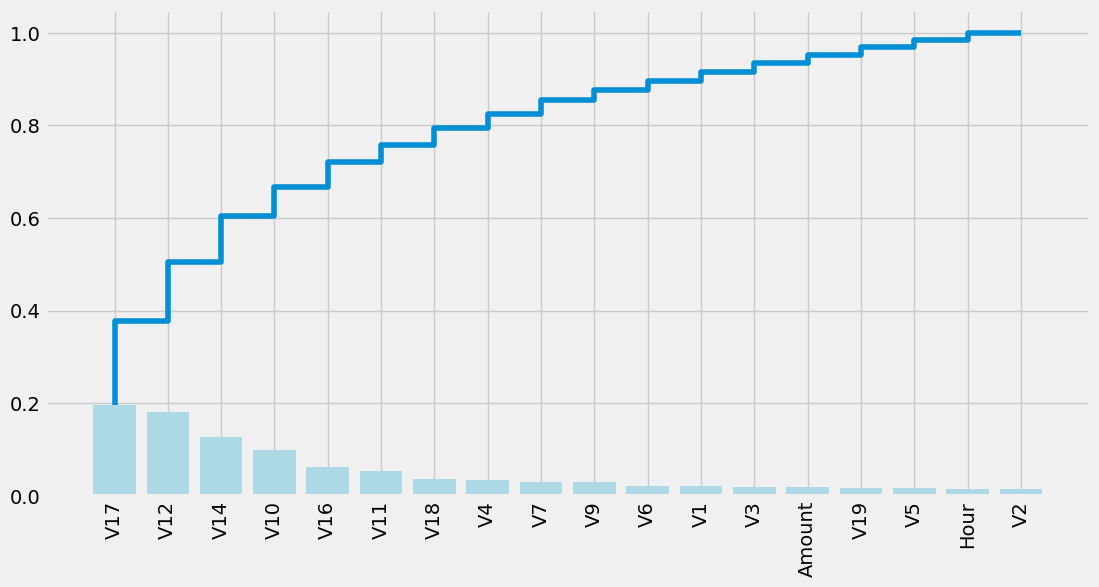

In [149]:
importance = clf.feature_importances_
feat_name = feature
feat_name = np.array(feat_name)
index = np.argsort(importance)[::-1]

plt.bar(range(len(index)),importance[index],color='lightblue')
plt.step(range(18),np.cumsum(importance[index]))
_ = plt.xticks(range(18),labels = feat_name[index],rotation='vertical',fontsize=14)

# 6.Model training

## 6.1 Oversampling

In [150]:
from imblearn.over_sampling import SMOTE

In [151]:
print('Samplee proportion before oversampling: \n',y.value_counts())

Samplee proportion before oversampling: 
 Class
0    284315
1       492
Name: count, dtype: int64


In [152]:
smote = SMOTE()

X,y = smote.fit_resample(X,y)
print('Samplee proportion after oversampling: \n',y.value_counts())

Samplee proportion after oversampling: 
 Class
0    284315
1    284315
Name: count, dtype: int64


## 6.2 Algorithm modeling

### 6.2.1 Accuracy

In [153]:
model = LogisticRegression()
model.fit(X,y) # Sample is balanced
y_ = model.predict(X)
print('Accuracy of logistic regression is :',accuracy_score(y,y_))

## Since we want the algorithm to detect fraud transactions, so accuracy is not suitable for model performance evaluation.

Accuracy of logistic regression is : 0.9384714137488349


### 6.2.2 Confusion matrix and recall

In [154]:
from sklearn.metrics import confusion_matrix

In [155]:
cm = confusion_matrix(y,y_)
recall = cm[1,1]/(cm[1,1]+cm[1,0])
print('Recall',recall)

Recall 0.9028331252308179


In [158]:
import itertools
def plot_confusion_matrix(cm,classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=0)
    plt.yticks(tick_marks,classes)

    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
            horizontalalignment="center",
        color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


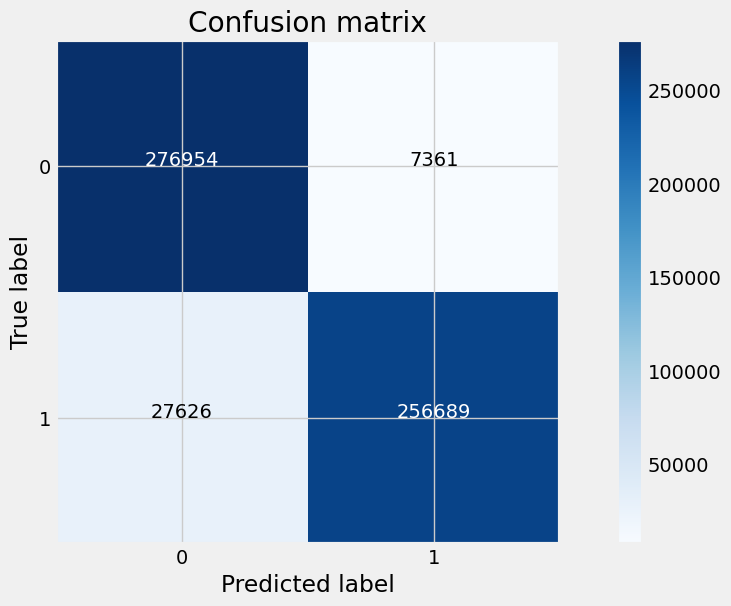

In [159]:
plot_confusion_matrix(cm,classes=[0,1])

### 6.2.3 ROC and AUC

Text(0.5, 0, 'False Positive Rate')

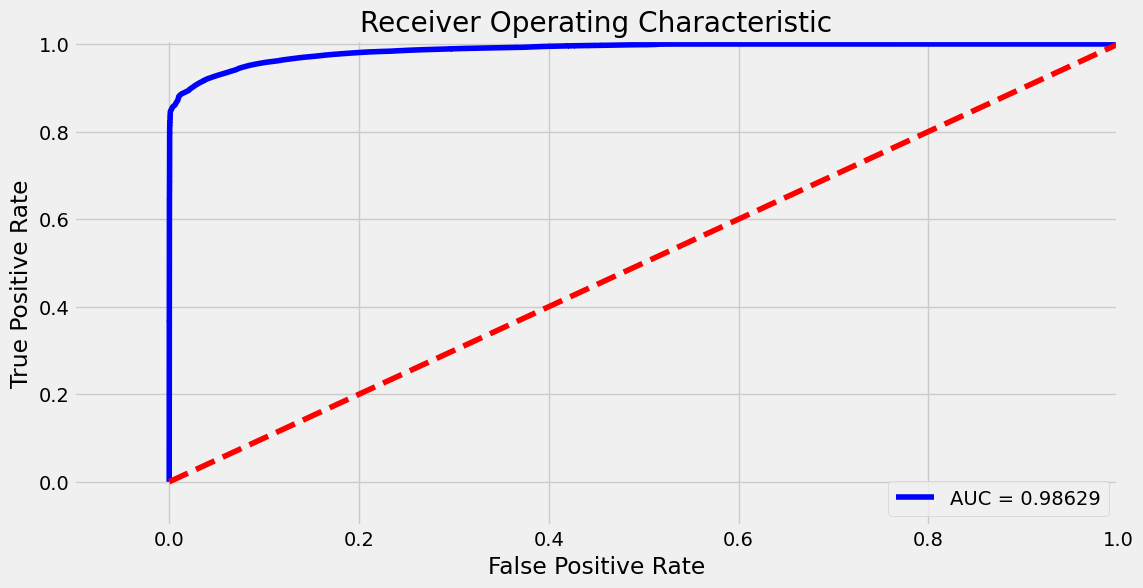

In [160]:
prob_ = model.predict_proba(X)[:,1]

fpr,tpr,thresholds = roc_curve(y,prob_)

roc_auc = auc(fpr,tpr)

## Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr,'b',label='AUC = %0.5f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


## 6.3 Cross-Validation

1. Cross-validation screening parameters

In [163]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

param_grid = {'C':[0.01,0.1,1,10,100,1000],'penalty':['l1','l2']}
              
grid_search = GridSearchCV(LogisticRegression(),param_grid,cv=10)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

2. View the optimal parameters

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
display(results)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:,.5f}".format(grid_search.best_score_))

Best parameters: {'C': 1000, 'penalty': 'l2'}
Best cross-validation score: 0.93862


3. Performance on test data

In [165]:
y_pred = grid_search.predict(X_test)

print('Accuracy: ', accuracy_score(y_test,y_pred))

Accuracy:  0.9387387228953801


4. Classification effectiveness assessment report

In [166]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     57110
           1       0.97      0.90      0.94     56616

    accuracy                           0.94    113726
   macro avg       0.94      0.94      0.94    113726
weighted avg       0.94      0.94      0.94    113726



## 6.4 Confusion matrix

Recall metric in the testing dataset:  0.9042143563656917


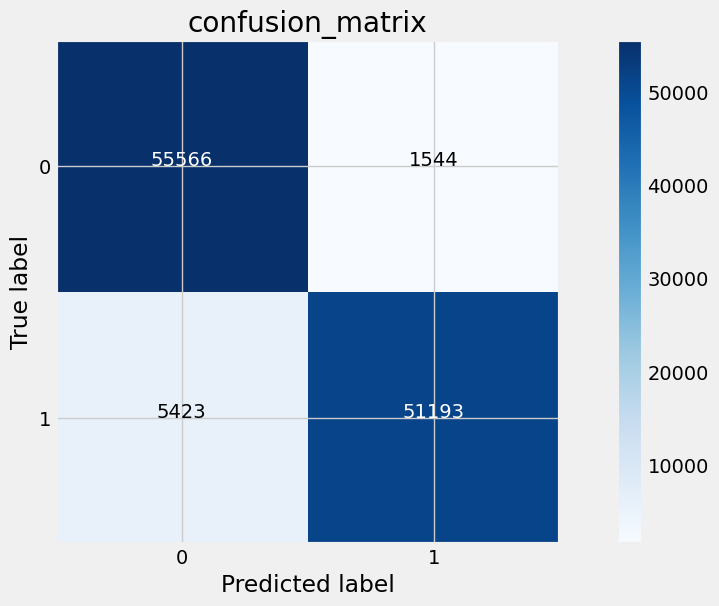

In [ ]:
# Generating confusion matrices for test data
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0] + cnf_matrix[1,1]))

# Plotting the confusion matrix after model optimization
class_name = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_name,
                      title='confusion_matrix')

Recall metric in the testing dataset:  0.903469743066669


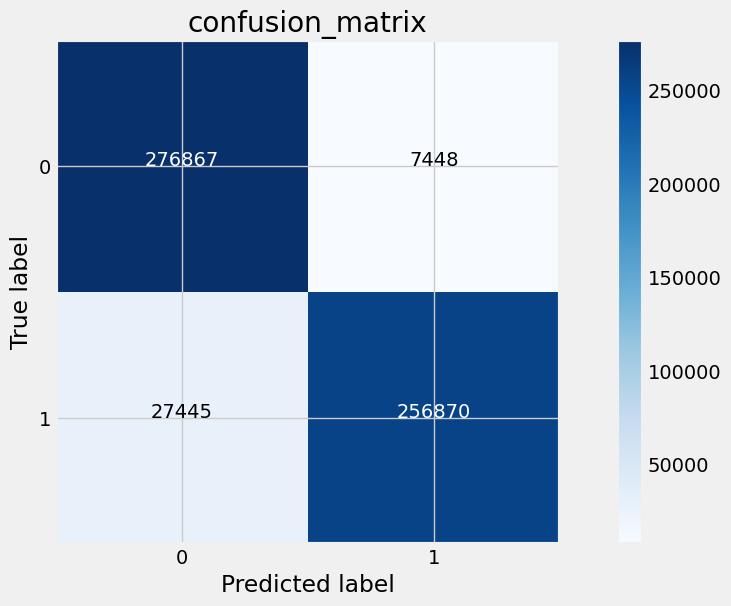

In [168]:
# Generating confusion matrices for all data

y_ = grid_search.predict(X) # Optimized algorithm

cnf_matrix = confusion_matrix(y,y_)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0] + cnf_matrix[1,1]))

# Plotting the confusion matrix after model optimization
class_name = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_name,
                      title='confusion_matrix')

# 7.Model evaluation

<div align="justify">

Solving different problems usually requires different metrics to measure the performance of the model. For example, if we want to use an algorithm to predict whether a cancer is positive or not, assuming that 5 out of 100 patients are positive for cancer, it is more important for a physician to improve the model's recall as much as possible than to improve the precision, because from the patient's perspective, it is more serious to have an omission of finding the cancer positive than to have a misdiagnosis that the cancer is positive.

</div>

## 7.1 Confusion matrix

Recall is : 0.9837678394800057	Precision is : 43718.48974728734
Recall is : 0.9570969337289812	Precision is : 51329.47646976065
Recall is : 0.9334110498798927	Precision is : 53708.464678261786
Recall is : 0.9185742546276671	Precision is : 54896.457292088
Recall is : 0.9042143563656917	Precision is : 55566.45014332695
Recall is : 0.8925922000847817	Precision is : 55993.444357490815
Recall is : 0.8866044934294193	Precision is : 56339.441376642106
Recall is : 0.8797336441995196	Precision is : 56507.437956140195
Recall is : 0.8650734774622015	Precision is : 56692.43065789705


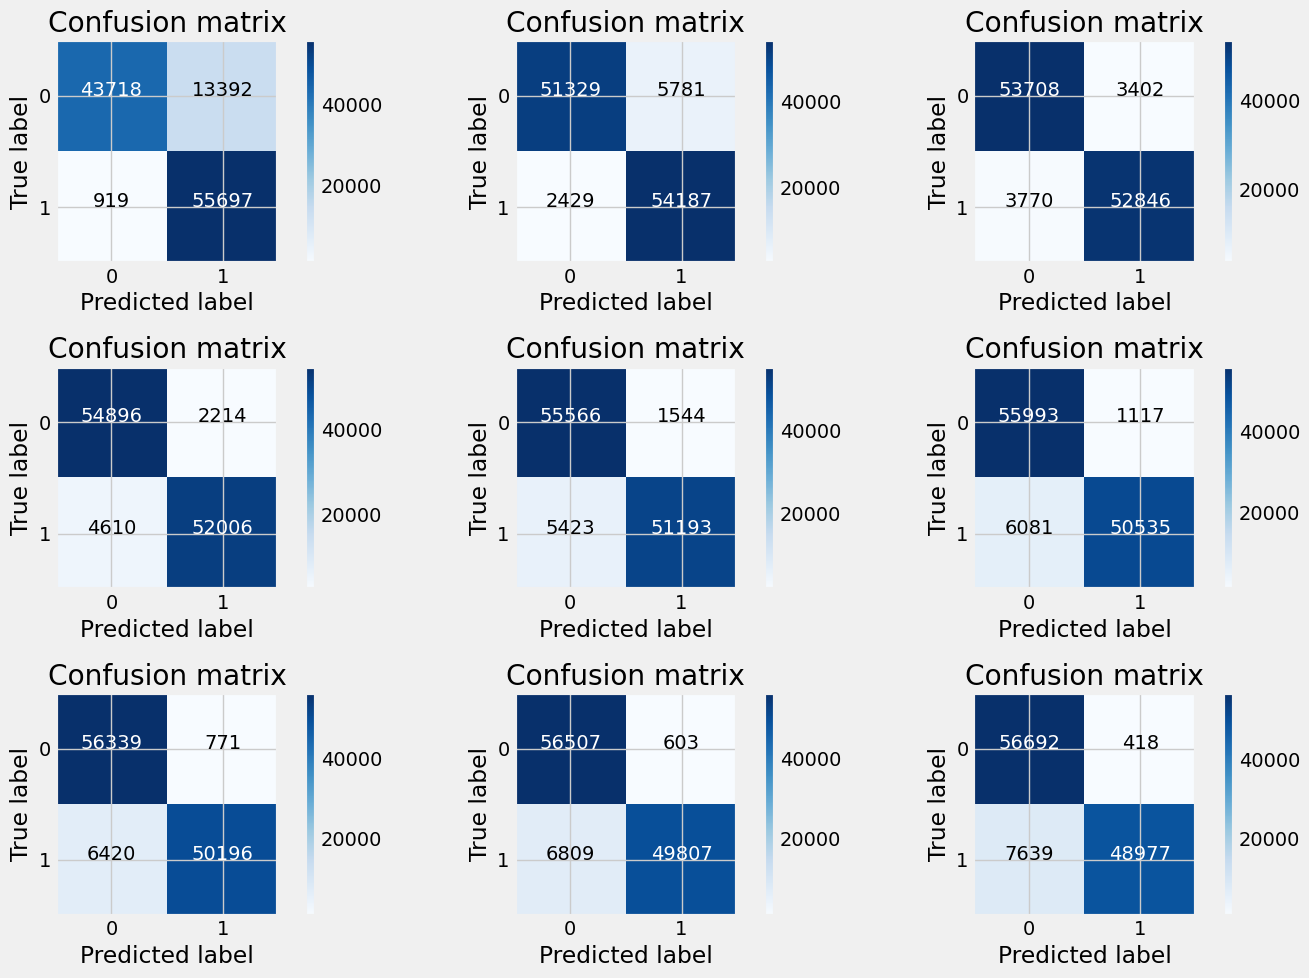

In [175]:
y_pred_proba = grid_search.predict_proba(X_test)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(15,10))
np.set_printoptions(precision=2)
j = 1
for t in thresholds:
    y_pred = y_pred_proba[:,1] > t
    plt.subplot(3,3,j)
    j += 1
    cnf_matrix = confusion_matrix(y_test,y_pred)
    print("Recall is :", cnf_matrix[1,1] / (cnf_matrix[1,0] + cnf_matrix[1,1]), end='\t')
    print("Precision is :",(cnf_matrix[0,0]+cnf_matrix[1,1]/(cnf_matrix.sum())))

    class_name = [0,1]
    plot_confusion_matrix(cnf_matrix,classes=class_name)

## 7.2 Precision - Recall

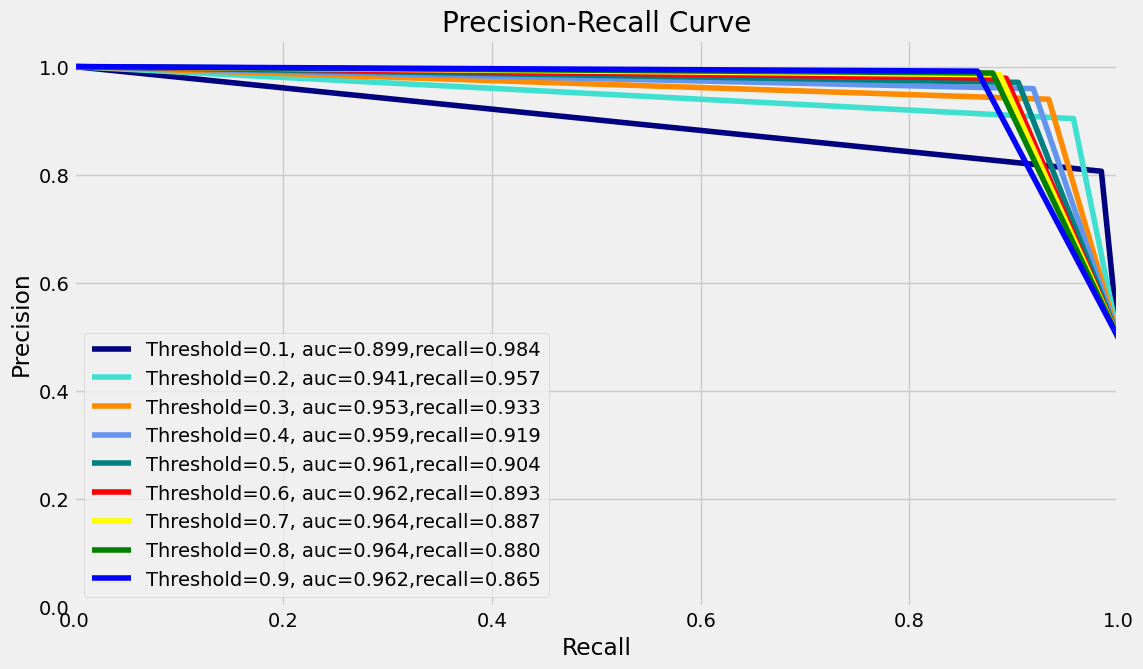

In [180]:
from sklearn.metrics import precision_recall_curve
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = ['navy','turquoise','darkorange','cornflowerblue','teal','red','yellow','green','blue']

plt.figure(figsize=(12,7))

j = 1
for t,color in zip(thresholds,colors):
    y_pred = y_pred_proba[:,1] > t
    
    precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
    area = auc(recall,precision)
    cm = confusion_matrix(y_test,y_pred)

    r = cm[1,1]/(cm[1,0]+cm[1,1])

    plt.plot(recall,precision,color=color,
             label='Threshold=%s, auc=%0.3f,recall=%0.3f' %(t,area,r))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

## 7.3 ROC curve

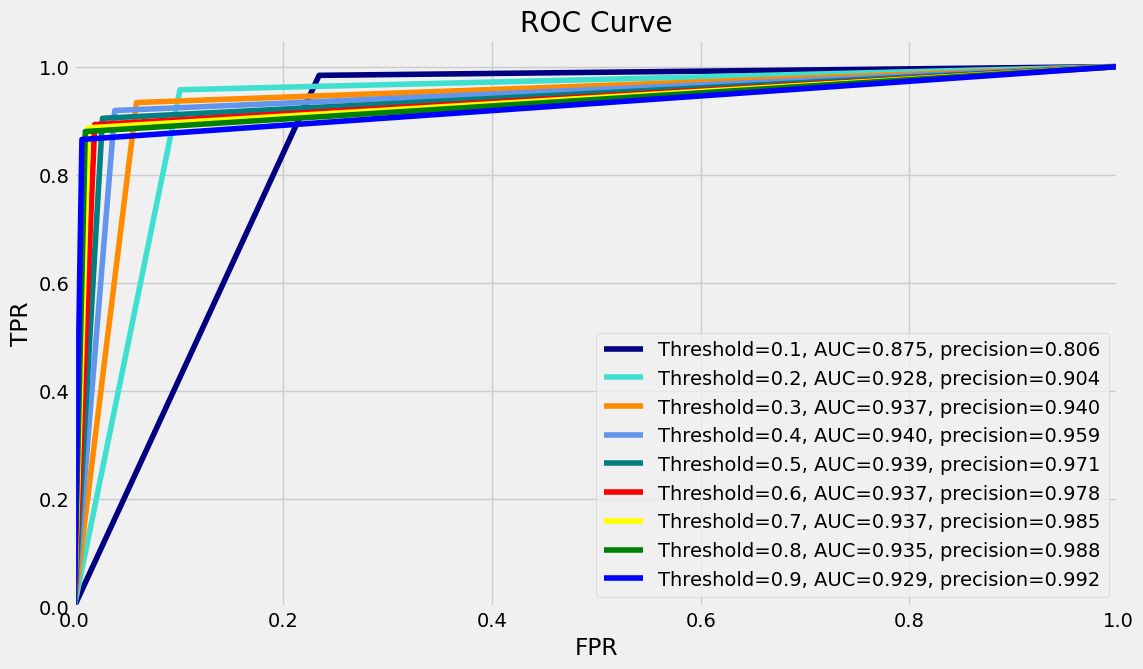

In [179]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = ['navy','turquoise','darkorange','cornflowerblue','teal','red','yellow','green','blue']

plt.figure(figsize=(12,7))

j = 1
for t,color in zip(thresholds,colors):
    y_pred = y_pred_proba[:,1] > t

    cm = confusion_matrix(y_test,y_pred)

    precision = cm[1,1]/(cm[0,1]+cm[1,1])

    fpr,tpr,_ = roc_curve(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)

    auc_=auc(fpr,tpr)

    plt.plot(fpr,tpr,color=color,
             label = 'Threshold=%s, AUC=%0.3f, precision=%0.3f' %(t, auc_,precision))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

## 7.4 Trend charts for each evaluation method

Text(0.5, 0, 'thresholds')

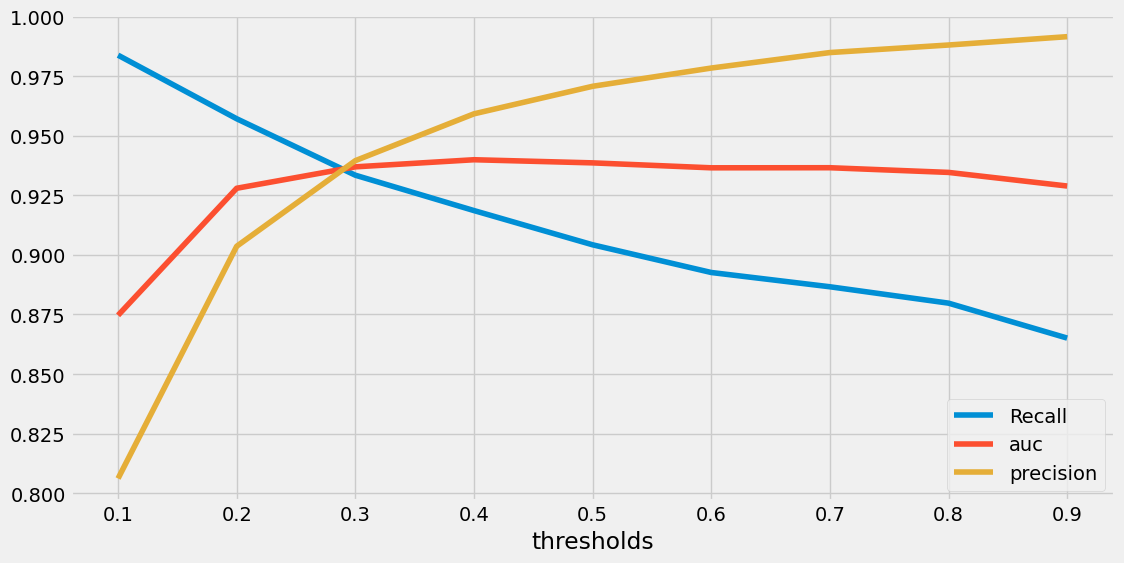

In [184]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

recalls = []
precisions = []
aucs = []
y_pred_proba = grid_search.predict_proba(X_test)
for threshold in thresholds:
    y_ = y_pred_proba[:,1] >= threshold
    cm = confusion_matrix(y_test,y_)

    recalls.append(cm[1,1]/(cm[1,0] + cm[1,1]))
    precisions.append(cm[1,1]/(cm[0,1] + cm[1,1]))
    fpr,tpr,_ = roc_curve(y_test,y_)
    auc_ = auc(fpr,tpr)
    aucs.append(auc_)

plt.figure(figsize=(12,6))
plt.plot(thresholds,recalls,label= 'Recall')
plt.plot(thresholds,aucs,label = 'auc')
plt.plot(thresholds,precisions,label = 'precision')
plt.legend()
plt.xlabel('thresholds')

## 7.5 Optimization threshold

<div align="justify">

Precision and recall are a contradictory set of variables. From the above confusion matrix and PRC curve, ROC curve can be seen, the smaller the threshold value, the larger the recall value, the model can find out the number of credit card theft is also with the terrier, but the price is the number of miscarriage of justice is also larger, with the increase of the threshold value, the recall value is gradually reduced, the precision value is also gradually increased, the number of miscarriage of justice is also reduced. By adjusting the model threshold, the strength of the model against credit card fraud is controlled, if you want to find out more credit card theft, set a smaller threshold, and vice versa, set a larger threshold.

In actual business, the choice of threshold depends on the comparison of marginal profit and marginal cost of the company's business. When the model threshold is set to a smaller value, it does find out more credit card holders with stolen credit cards, but with the increase in the number of misjudgments, it not only increases the workload of the post-loan team, but also reduces the consumption experience of the customers who are misjudged as stolen credit card holders, which leads to a decrease in customer satisfaction. If a certain model threshold can make the business marginal profit and marginal cost to reach a balance, then the threshold value of the model is the optimal value. Of course there are exceptions, when there is a financial crisis, it is often accompanied by an increased chance of loan default or credit card theft, and financial institutions will be more willing to hold the line on risk at all costs.

</div>